In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install idx2numpy


In [2]:
import numpy as np
import idx2numpy
import matplotlib.pyplot as plt

## Creating a neural network with three layers
####  1. Input Layer (784 neurons)
####  2. One Hidden Layer (10 neurons)
####  3. Output Layer (10 neurons)

First, converting from idx3-ubyte to an array

0


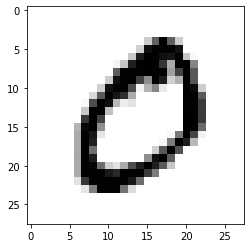

In [3]:
# Name of the file
imagefile = 'train-images.idx3-ubyte'
labelfile = 'train-labels.idx1-ubyte'

# Converting
imagearray = idx2numpy.convert_from_file(imagefile)
labelarray = idx2numpy.convert_from_file(labelfile)


plt.imshow(imagearray[1], cmap=plt.cm.binary);
print(labelarray[1])



In [4]:
print(imagearray.shape)
print(labelarray.shape)

(60000, 28, 28)
(60000,)


This example contains 60000 images of handwritten digits with dimension 28x28. Each unit represents the grayscale value from range 0-255

First, we flatten the 28x28 array into 784 sized array

In [8]:
# Flattening
X_flat = np.zeros((60000,28*28))
for i in range(len(imagearray)):
    X_flat[i] = imagearray[i].flatten()
X_flat.shape
Y = labelarray
Y.shape

(60000,)

Normalzing the grayscale values in range 0-1

In [9]:
X_flat = X_flat / 255

Splitting the date into training set and testing set

In [10]:
X_train = X_flat[:54000]
Y_train = Y[:54000]
X_test = X_flat[54000:]
Y_test = Y[54000:]

Tranposing the array so that it can be fed into the network

In [11]:
X_train = X_train.T
X_test = X_test.T
print(X_train.shape)
print(X_test.shape)

(784, 54000)
(784, 6000)


In [12]:
# Initiliazing parameters betweeen -0.5 to 0.5 with uniform distribution

def init_params():
    
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    
    return W1, b1, W2, b2

## Forward Propagation

First, some weight is applied to each feature (pixel) of the image and a bias term is added. That is

Z1 = W1.X + B1

Then, we send the output to an activation function. (ReLU in this case)


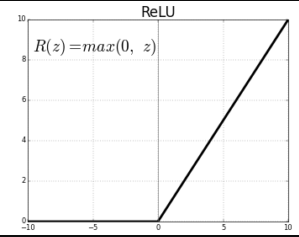

A1 = ReLU(Z1)

Then, we send the activation of the first layer as an input to the second layer by adding weights and biases.

Z2 = W2.A1 + B2

Finally, we apply a softmax activation function to get output in term of probability.

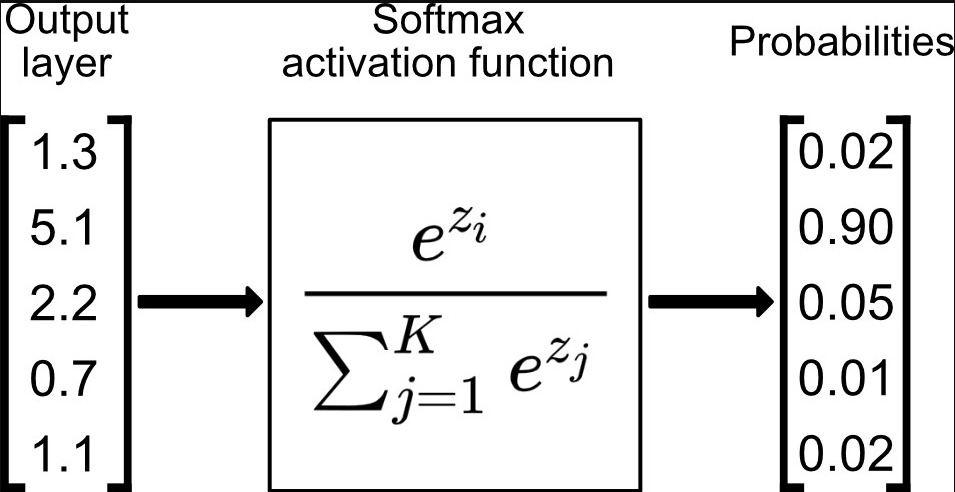

A2 = SoftMax(Z2)

In [13]:
# Rectified Linear Unit Function to be used as activation for the first layer

def ReLU(Z):
    return np.maximum(Z, 0)

# Softmax activation function to be used for final layer

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

In [14]:
def forward_prop(W1, b1, W2, b2, X):
    
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    
    return Z1, A1, Z2, A2

Currently, the value of Y is the label of that index of X. Meaning X[10] has image of value of Y[10].

In order to calculate the loss, we need to one hot encode the Y value.

For example:

If Y[0] = 2 then after one hot encoding, the value of Y[0] will be $\begin{pmatrix}
0 \\
0 \\
1 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0
\end{pmatrix}$

In [15]:
# Function to one hot encode the label
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

In this neural network, we will be using cross entropy loss function. This loss function is better than sum of squared residual (SSR) loss function because this loss function punishes the loss heavily.

$J = \sum_{i=1}^{c} -y_{i} log(\hat{y}_{i})$

$c$ = Number of classes (10 in this case)

$y_{i}$ = Actual value

$\hat{y}_{i}$ = Predicted value

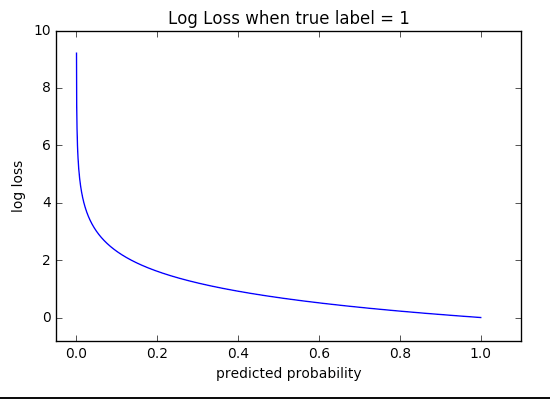

Like any other machine learning algorithm, the main objective here is to minimize the loss function. In order to do that in neural network, we use backward propagation or backprop.

## Backward propagation

The main step in backprop is to find the partial derivative of the loss function with respect to each weights and biases. This partial derivative term says how much each feature plays a role in determining the final outcome. The more the partial gradient, the more important the feature is. After we calculate the partial derivative, we change the respective weights and biases to some multiple of the partial derivative. 

That is:

$W2 = W2 - \alpha \frac{\partial J}{\partial W2}$

$B2 = B2 - \alpha \frac{\partial J}{\partial B2}$

$W1 = W1 - \alpha \frac{\partial J}{\partial W1}$

$B1 = B1 - \alpha \frac{\partial J}{\partial B1}$

where $\alpha$ is the learning rate.


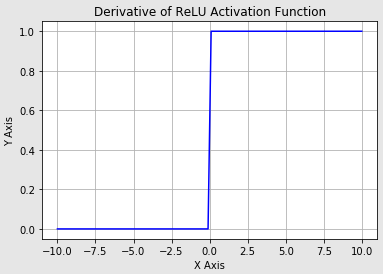

In [16]:
# Derivative of the ReLU activation function
def ReLU_deriv(Z):
    return Z > 0


In [23]:

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    
    m = X.shape[1]
    
    # One hot encoding Y
    one_hot_Y = one_hot(Y)
    
    # partial derivative of Z2
    dZ2 = A2 - one_hot_Y
    
    # partial derivatives of weights and biases
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    
    # partial derivative of Z1
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    
    # partial derivatives of weights and biases
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    
    return dW1, db1, dW2, db2

In [24]:
def forward_feed(W1, b1, W2, b2, X):    
    
    # Hidden Layer
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    
    # Final Layer
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    
    return Z1, A1, Z2, A2

In [25]:
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    
    # Updating each parameter to some multiple (learning rate) of parital derivatives
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2  
    
    return W1, b1, W2, b2
    

In [26]:
def get_predictions(A2):
    # Decoding the one hot encoded(somewhat) output
    return np.argmax(A2, axis=0)

def get_accuracy(predictions, Y):
    # Dividing total correct predictions by total number of predictions
    return np.sum(predictions == Y) / Y.size



In [27]:
def gradient_descent(X, Y, alpha, iterations):
    # Initilaizing weights and biases
    W1, b1, W2, b2 = init_params()
    
    for i in range(iterations):
        # Forward Feed
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        # Backward Propagation
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        # Updating parameters based upon partial derivatives
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        
        # Checking progress each 10 iterations
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
            
    return W1, b1, W2, b2

In [28]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.10, 500)

Iteration:  0
0.13548148148148148
Iteration:  10
0.2039074074074074
Iteration:  20
0.262037037037037
Iteration:  30
0.33201851851851855
Iteration:  40
0.3852407407407407
Iteration:  50
0.4285185185185185
Iteration:  60
0.4703703703703704
Iteration:  70
0.5109444444444444
Iteration:  80
0.5492777777777778
Iteration:  90
0.5839444444444445
Iteration:  100
0.6171666666666666
Iteration:  110
0.6436481481481482
Iteration:  120
0.6668518518518518
Iteration:  130
0.6862222222222222
Iteration:  140
0.7024814814814815
Iteration:  150
0.7152037037037037
Iteration:  160
0.7257222222222223
Iteration:  170
0.7360925925925926
Iteration:  180
0.7451111111111111
Iteration:  190
0.7534444444444445
Iteration:  200
0.7607407407407407
Iteration:  210
0.766537037037037
Iteration:  220
0.7725740740740741
Iteration:  230
0.7779074074074074
Iteration:  240
0.7832222222222223
Iteration:  250
0.7873703703703704
Iteration:  260
0.7917037037037037
Iteration:  270
0.7955
Iteration:  280
0.7995740740740741
Iteratio

In [29]:
# A function that returns predictions with calulated parameters
def make_predictions(X, W1, b1, W2, b2):
    # Forward feed
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    # Decoding
    predictions = get_predictions(A2)
    return predictions

In [30]:
def test_prediction(index, W1, b1, W2, b2):
    
    # Getting the image from label
    current_image = X_test[:, index, None]
    # Making prediction
    prediction = make_predictions(X_test[:, index, None], W1, b1, W2, b2)
    # Getting label
    label = Y_test[index]
    
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    # Reshaping the flattened image and undoing normalization
    current_image = current_image.reshape((28, 28)) * 255
    
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [5]
Label:  5


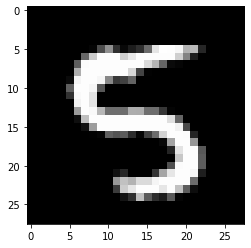

Prediction:  [6]
Label:  6


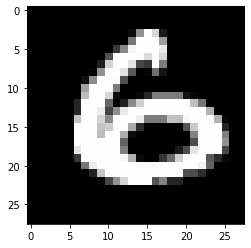

Prediction:  [8]
Label:  7


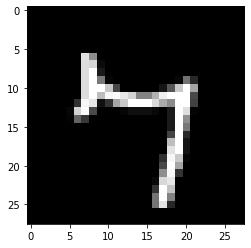

Prediction:  [0]
Label:  0


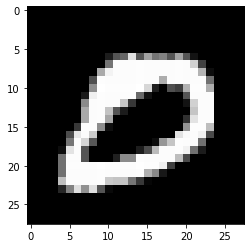

In [33]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(68, W1, b1, W2, b2)
test_prediction(278, W1, b1, W2, b2)
test_prediction(999, W1, b1, W2, b2)

In [34]:
test_predictions = make_predictions(X_test, W1, b1, W2, b2)
get_accuracy(test_predictions, Y_test)

0.8746666666666667

An accuracy of 87% is pretty good for a simple neural network with little to no optizations.

### References

* https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi
* https://www.youtube.com/watch?v=CqOfi41LfDw
* http://neuralnetworksanddeeplearning.com/
* https://www.samsonzhang.com/2020/11/24/understanding-the-math-behind-neural-networks-by-building-one-from-scratch-no-tf-keras-just-numpy.html